# Chapter 1: Well Testing Analysis
**Author:** Ade Anggi Naluriawan Santoso
### Based on "Advanced Reservoir Engineering" by Tarek Ahmed & Paul D. McKinney

**Objective:**
This notebook covers the fundamental concepts of transient pressure analysis. We will build Python tools to analyze pressure drawdown and buildup tests, focusing on:
1.  **Fluid Properties:** Basic correlations for calculating oil properties.
2.  **Dimensionless Variables:** Understanding $P_D$ and $t_D$.
3.  **The Diffusivity Equation:** Visualizing pressure propagation using the Line Source Solution.
4.  **Semi-Log Analysis (Horner Plot):** Conventional analysis for permeability ($k$) and Skin ($s$).
5.  **Type Curve Analysis (Diagnostic Plots):** Log-log plots of pressure change and pressure derivative to identify flow regimes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expi  # Exponential integral function for Line Source Solution
from scipy.optimize import curve_fit # For regression analysis

# Set plot style for professional engineering plots
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Fluid & Rock Properties

Before analyzing pressure data, we need reliable values for the formation and fluid properties. In a real scenario, these come from PVT reports and core analysis.

For this exercise, we will define a Python class `ReservoirParameters` to hold these constants, and helper functions to calculate Formation Volume Factor ($B_o$) and Viscosity ($\mu_o$) if they are not explicitly given (using simplified correlations for demonstration).

In [2]:
class ReservoirParameters:
    def __init__(self, pi, poro, ct, rw, h, mu=None, Bo=None):
        """
        Initialize reservoir parameters.
        
        Args:
            pi (float): Initial reservoir pressure (psi)
            poro (float): Porosity (fraction)
            ct (float): Total compressibility (1/psi)
            rw (float): Wellbore radius (ft)
            h (float): Net pay thickness (ft)
            mu (float): Oil viscosity (cp). If None, will be calculated.
            Bo (float): Oil FVF (rb/stb). If None, will be calculated.
        """
        self.pi = pi
        self.poro = poro
        self.ct = ct
        self.rw = rw
        self.h = h
        self.mu = mu if mu is not None else 1.0 # Default fallback or place correlation here
        self.Bo = Bo if Bo is not None else 1.2 # Default fallback or place correlation here

    def __str__(self):
        return (f"Reservoir Params:\n"
                f"  Pi: {self.pi} psi\n"
                f"  Porosity: {self.poro}\n"
                f"  Ct: {self.ct} 1/psi\n"
                f"  rw: {self.rw} ft\n"
                f"  h: {self.h} ft\n"
                f"  Viscosity: {self.mu} cp\n"
                f"  Bo: {self.Bo} rb/stb")

# Example Initialization
res_props = ReservoirParameters(
    pi=3000, 
    poro=0.15, 
    ct=1.2e-5, 
    rw=0.328, 
    h=50, 
    mu=2.5, 
    Bo=1.15
)
print(res_props)

Reservoir Params:
  Pi: 3000 psi
  Porosity: 0.15
  Ct: 1.2e-05 1/psi
  rw: 0.328 ft
  h: 50 ft
  Viscosity: 2.5 cp
  Bo: 1.15 rb/stb


## 2. Dimensionless Variables

In reservoir engineering, we often work with dimensionless variables to generalize solutions across different reservoirs.

**Dimensionless Time ($t_D$):**
$$t_D = \frac{0.0002637 k t}{\phi \mu c_t r_w^2}$$

**Dimensionless Pressure ($P_D$):**
$$P_D = \frac{kh (P_i - P_{wf})}{141.2 q B \mu}$$

Where:
* $k$ = permeability (md)
* $t$ = time (hours)
* $q$ = flow rate (STB/D)

In [3]:
def calculate_tD(t, k, poro, mu, ct, rw):
    """
    Calculates Dimensionless Time (tD).
    t: Time in hours
    k: Permeability in md
    """
    # Constant 0.0002637 is for Field Units
    return (0.0002637 * k * t) / (poro * mu * ct * (rw**2))

def calculate_pD(pi, pwf, k, h, q, Bo, mu):
    """
    Calculates Dimensionless Pressure (pD).
    pwf: Flowing bottomhole pressure
    """
    dp = pi - pwf
    return (k * h * dp) / (141.2 * q * Bo * mu)

## 3.a. The Diffusivity Equation

The fundamental equation governing radial flow of slightly compressible fluids is the Diffusivity Equation. The **Line Source Solution** (Theis solution) is the most common analytical solution used in well testing.

$$P(r, t) = P_i - \frac{70.6 q B \mu}{kh} \left[ -Ei \left( -\frac{948 \phi \mu c_t r^2}{kt} \right) \right]$$

The Exponential Integral function, $-Ei(-x)$, approximates $\ln(x)$ for small arguments (late time or small radius).

Let's visualize how pressure drops (propagates) away from the wellbore over time.

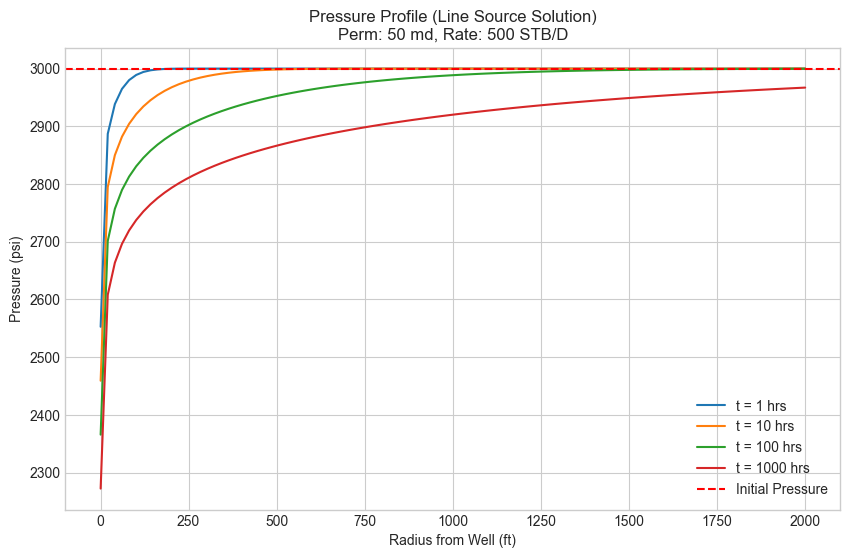

In [4]:
def line_source_pressure(r, t, q, res: ReservoirParameters, k):
    """
    Calculate pressure at radius r and time t using Line Source Solution.
    """
    # Argument for Ei function (u)
    # u = (948 * poro * mu * ct * r^2) / (k * t)
    u = (948 * res.poro * res.mu * res.ct * (r**2)) / (k * t)
    
    # Calculate Pressure Drop (Delta P)
    # dP = (70.6 * q * Bo * mu) / (k * h) * (-Ei(-u))
    # Note: scipy.special.expi returns Ei(x), we need -Ei(-u)
    # For standard library, expi(-u) is the correct implementation of -E_1(u) roughly speaking in physics context
    # However, strictly: P = Pi + (Constant * Ei(-u)) because Ei(-x) is negative.
    
    dp = (70.6 * q * res.Bo * res.mu) / (k * res.h) * (-expi(-u))
    
    return res.pi - dp

# --- Visualization ---
r_values = np.linspace(res_props.rw, 2000, 100) # From wellbore to 2000 ft
times = [1, 10, 100, 1000] # Hours
q_test = 500 # STB/D
k_test = 50 # md

plt.figure(figsize=(10, 6))

for t in times:
    p_profile = line_source_pressure(r_values, t, q_test, res_props, k_test)
    plt.plot(r_values, p_profile, label=f't = {t} hrs')

plt.title(f'Pressure Profile (Line Source Solution)\nPerm: {k_test} md, Rate: {q_test} STB/D')
plt.xlabel('Radius from Well (ft)')
plt.ylabel('Pressure (psi)')
plt.axhline(res_props.pi, color='red', linestyle='--', label='Initial Pressure')
plt.legend()
plt.grid(True)
plt.show()

## 3b. Early Time Analysis: Wellbore Storage
Before the reservoir fluid starts flowing into the wellbore, we are simply expanding the fluid currently sitting in the casing/tubing. This is **Wellbore Storage**.

On a Log-Log plot, this appears as a **Unit Slope** line (slope = 1). We can calculate the Storage Coefficient ($C$) from any point $(\Delta t, \Delta P)$ on this straight line.

$$C = \frac{q B}{24} \left( \frac{\Delta t}{\Delta P} \right)$$

* $C$ is in bbl/psi.

In [10]:
def calculate_wellbore_storage(q, B, dt_point, dp_point):
    """
    Calculates Wellbore Storage Coefficient (C) from a point on the unit slope line.
    dt_point: Time on unit slope (hours)
    dp_point: Pressure drop at that time (psi)
    """
    # C = (q * B / 24) * (dt / dp)
    C = (q * B / 24.0) * (dt_point / dp_point)
    return C

# Example: Pick a very early time point from our synthetic data (assuming it was WBS dominated)
# In real analysis, you pick this manually from the log-log plot
t_wbs = 0.01  # hours
dp_wbs = 10.0 # psi (Hypothetical point on unit slope)

C_calc = calculate_wellbore_storage(q_buildup, res_props.Bo, t_wbs, dp_wbs)
print(f"Wellbore Storage Coefficient (C): {C_calc:.4f} bbl/psi")

# Dimensionless Wellbore Storage (CD)
# CD = (0.8936 * C) / (phi * ct * h * rw^2)
CD = (0.8936 * C_calc) / (res_props.poro * res_props.ct * res_props.h * res_props.rw**2)
print(f"Dimensionless Storage (CD): {CD:.0f}")

Wellbore Storage Coefficient (C): 0.0479 bbl/psi
Dimensionless Storage (CD): 4422


## 4.a. Semi-Log Analysis (Horner Plot)

For a **Pressure Buildup Test**, we shut the well in after a flowing period ($t_p$). We analyze the pressure recovery ($P_{ws}$) vs. the **Horner Time Ratio (HTR)**.

$$HTR = \frac{t_p + \Delta t}{\Delta t}$$

On a semi-log plot ($P_{ws}$ vs $\log(HTR)$), the data should form a straight line during the Infinite Acting Radial Flow (IARF) period.

**Calculations from Slope ($m$):**
1.  **Permeability ($k$):**
    $$k = \frac{162.6 q B \mu}{m h}$$
2.  **Skin Factor ($s$):**
    $$s = 1.151 \left[ \frac{P_{1hr} - P_{wf(\Delta t=0)}}{m} - \log\left(\frac{k}{\phi \mu c_t r_w^2}\right) + 3.23 \right]$$

Let's generate some synthetic noisy buildup data and analyze it.

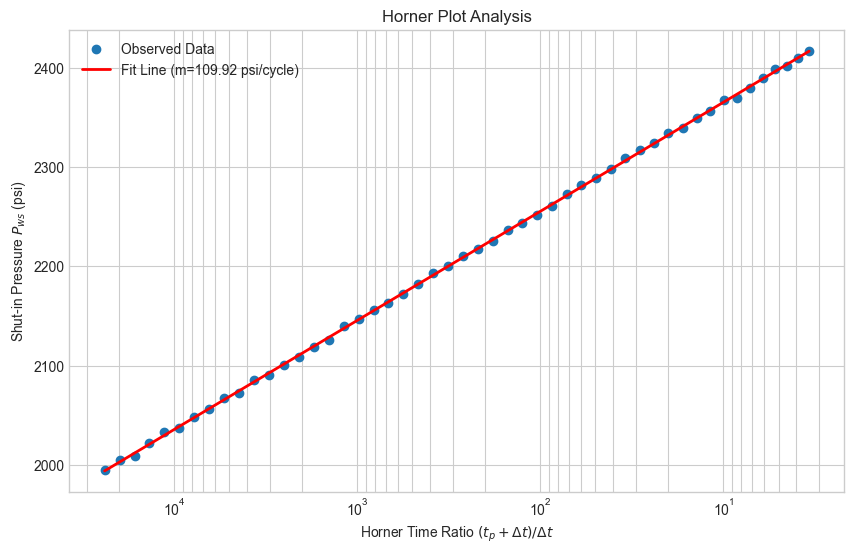

--- RESULTS ---
Calculated Permeability (k): 85.06 md (Real: 85)
Calculated Skin (s): -3.48 (Real: 2.5)


In [5]:
# 1. Generate Synthetic Data (representing a buildup test)
tp = 240 # Production time before shut-in (hours)
q_buildup = 1000 # STB/D (rate before shutin)
k_real = 85 # md (Hidden truth)
s_real = 2.5 # Skin (Hidden truth)

# Delta t (shut-in time) array
dt_values = np.logspace(-2, 2, 50) # 0.01 to 100 hours

# Calculate theoretical pressure using Superposition Principle
# P_ws = Pi - (Slope * log((tp+dt)/dt)) roughly, but let's use full superposition with Ei
def superposition_time_function(t, tp):
    return np.log10((tp + t) / t)

# Theoretical Slope m
m_theo = (162.6 * q_buildup * res_props.Bo * res_props.mu) / (k_real * res_props.h)

# Generate synthetic pressures (Ideal Straight Line + Skin drop)
# Pws = Pi - m * log((tp+dt)/dt) (Simplified for infinite acting)
# Note: This is a simplified generation for the exercise.
# Real generation would involve Ei functions for both flow and shut-in periods.
horner_time = (tp + dt_values) / dt_values
p_ws = res_props.pi - m_theo * np.log10(horner_time) 

# Add Skin effect (constant pressure drop removed during buildup)
# Skin pressure drop Dp_skin = 0.869 * m * s
dp_skin = 0.869 * m_theo * s_real
# Since it's buildup, pressure is HIGHER than flowing, but skin causes restriction.
# Actually, let's just use the P1hr equation in reverse to seed the data:
p_1hr_theoretical = res_props.pi - m_theo * (np.log10(k_real/(res_props.poro*res_props.mu*res_props.ct*res_props.rw**2)) - 3.23 + 0.869*s_real)

# Adjust synthetic data to match this P1hr at HTR corresponding to 1 hr
p_ws = p_ws - (p_ws[np.abs(dt_values - 1.0).argmin()] - p_1hr_theoretical)

# Add random noise to simulate real gauge data
noise = np.random.normal(0, 2, size=len(p_ws)) # +/- 2 psi noise
p_ws_noisy = p_ws + noise

# --- ANALYSIS START ---

# 2. Calculate Horner Time Ratio
htr = (tp + dt_values) / dt_values

# 3. Plotting
plt.figure(figsize=(10, 6))
plt.semilogx(htr, p_ws_noisy, 'o', label='Observed Data')

# 4. Regression (Fit a straight line to the semi-log data)
# We usually fit the "middle time" region. Let's assume all data here is IARF for simplicity.
# Fit P = A + B * log10(HTR)
coeffs = np.polyfit(np.log10(htr), p_ws_noisy, 1)
slope_m = -coeffs[0] # Slope is negative on the plot (increasing HTR = decreasing time), but we take absolute for formula
intercept = coeffs[1]

# Calculate line for plotting
fit_line = -slope_m * np.log10(htr) + intercept
plt.plot(htr, fit_line, 'r-', linewidth=2, label=f'Fit Line (m={slope_m:.2f} psi/cycle)')

plt.xlabel('Horner Time Ratio $(t_p + \Delta t) / \Delta t$')
plt.ylabel('Shut-in Pressure $P_{ws}$ (psi)')
plt.title('Horner Plot Analysis')
plt.legend()
plt.gca().invert_xaxis() # Standard Horner convention: HTR decreases to the right (Infinite time = 1)
plt.grid(True, which="both")
plt.show()

# 5. Calculate Results
k_calc = (162.6 * q_buildup * res_props.Bo * res_props.mu) / (slope_m * res_props.h)

# P_1hr is found on the fit line where HTR = (tp+1)/1 approx tp if tp >> 1
p_1hr_calc = -slope_m * np.log10((tp+1)/1) + intercept
pwf_at_shut_in = p_ws_noisy[0] # Approximate with first point or provided data

s_calc = 1.151 * ((p_1hr_calc - pwf_at_shut_in) / slope_m 
                  - np.log10(k_calc / (res_props.poro * res_props.mu * res_props.ct * res_props.rw**2)) 
                  + 3.23)

print(f"--- RESULTS ---")
print(f"Calculated Permeability (k): {k_calc:.2f} md (Real: {k_real})")
print(f"Calculated Skin (s): {s_calc:.2f} (Real: {s_real})")

## 4b. Principle of Superposition (Variable Rate)
Real wells rarely produce at a constant rate for their entire life. Tarek Ahmed emphasizes the **Principle of Superposition** to handle multi-rate flow sequences.

$$P_i - P_{wf}(t) = \frac{162.6 B \mu}{k h} \sum_{j=1}^{n} (q_j - q_{j-1}) \log(t - t_{j-1})$$

We can define a **Superposition Time Function** to linearize this complex history into a single variable for plotting.

In [11]:
def superposition_time_variable_rate(t_current, rate_history, time_history):
    """
    Calculates the Superposition Time Function X(t) for variable rate history.
    
    t_current: The current time we are evaluating
    rate_history: List of rates [q1, q2, q3...]
    time_history: List of times when rates CHANGED [0, t1, t2...]
                  (Length must match rate_history)
    """
    # This function calculates the summation term for the plotting function
    # Sum [ (q_j - q_{j-1}) * log(t - t_{j-1}) ]
    
    superposition_sum = 0
    q_prev = 0
    
    for i in range(len(rate_history)):
        q_now = rate_history[i]
        t_change = time_history[i]
        
        if t_current > t_change:
            term = (q_now - q_prev) * np.log10(t_current - t_change)
            superposition_sum += term
            
        q_prev = q_now
        
    return superposition_sum

# Example Usage:
# Rate 1: 500 STB/D for 24 hours
# Rate 2: 800 STB/D for 24 hours (Total 48)
# Rate 3: 0 STB/D (Shut-in)
rates = [500, 800, 0]
times = [0, 24, 48]

# Calculate superposition function at t=50 (2 hours into shut-in)
val = superposition_time_variable_rate(50, rates, times)
print(f"Superposition Value at t=50: {val:.4f}")

Superposition Value at t=50: 1033.1530


## 5.a. Type Curve Analysis (Diagnostic Plot)

Modern analysis relies heavily on the **Pressure Derivative**. This helps identify flow regimes (Wellbore Storage, Radial Flow, Boundary Effects) that are hard to see on a Horner plot.

**Bourdet Derivative Calculation:**
$$\text{Derivative} = \frac{d(\Delta P)}{d(\ln \Delta t)} = \Delta t \cdot \frac{d(\Delta P)}{d(\Delta t)}$$

**Flow Regimes on Log-Log Plot:**
1.  **Wellbore Storage:** Unit slope (Straight line with slope = 1).
2.  **Infinite Acting Radial Flow (IARF):** Horizontal line (Zero slope derivative).
3.  **Boundaries:** Derivative curves up (closed) or down (constant pressure).

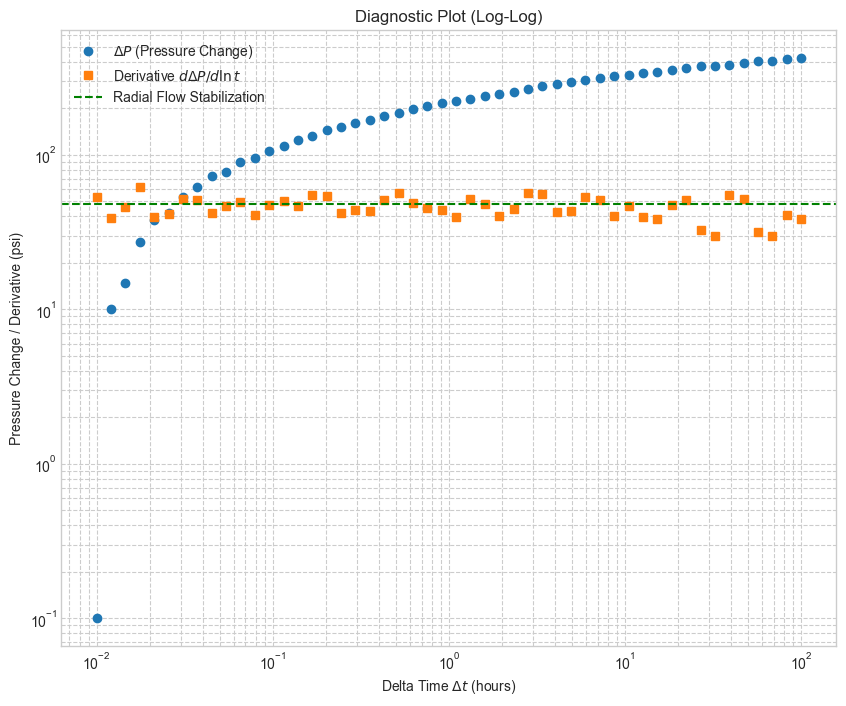

Interpretation:
The flat region of the derivative indicates Infinite Acting Radial Flow.
Derivative Stabilization Value: 40.78 psi
Theoretical Stabilization (m / 2.303): 47.73 psi


In [6]:
def calculate_bourdet_derivative(dt, dp):
    """
    Calculates the Bourdet derivative: d(dP)/d(ln t).
    Using simple central difference for demonstration.
    """
    # Calculate natural log of time
    lnt = np.log(dt)
    
    # Calculate derivative dy/dx
    # We'll use numpy gradient for simplicity
    deriv = np.gradient(dp, lnt)
    return deriv

# Create Delta P array (P_ws - P_wf_shutin)
delta_p = p_ws_noisy - p_ws_noisy[0]
# Avoid zero/negative values for log plot
delta_p[delta_p <= 0] = 0.1 

# Calculate Derivative
derivative = calculate_bourdet_derivative(dt_values, delta_p)

# Visualization (Log-Log) 
plt.figure(figsize=(10, 8))
plt.loglog(dt_values, delta_p, 'o', label=r'$\Delta P$ (Pressure Change)')
plt.loglog(dt_values, derivative, 's', label=r'Derivative $d\Delta P / d\ln t$')

# Highlight the Radial Flow stabilization
plt.axhline(slope_m / 2.303, color='green', linestyle='--', label='Radial Flow Stabilization')
# Note: In field units, Derivative Plateau = m / 2.303

plt.title('Diagnostic Plot (Log-Log)')
plt.xlabel('Delta Time $\Delta t$ (hours)')
plt.ylabel('Pressure Change / Derivative (psi)')
plt.legend()
plt.grid(True, which="both", linestyle='--')
plt.show()

print("Interpretation:")
print("The flat region of the derivative indicates Infinite Acting Radial Flow.")
print(f"Derivative Stabilization Value: {np.mean(derivative[-10:]):.2f} psi")
print(f"Theoretical Stabilization (m / 2.303): {slope_m / 2.303:.2f} psi")

## 5b. Identifying Other Flow Regimes
The derivative plot is the most powerful tool for identifying reservoir geometry. Tarek Ahmed lists specific slopes that correspond to specific physical regimes:

| Flow Regime | Characteristic Slope on Log-Log Derivative | Physical Meaning |
| :--- | :--- | :--- |
| **Wellbore Storage** | +1 (Unit Slope) | Fluid expanding in tubing |
| **Radial Flow** | 0 (Horizontal) | Infinite acting reservoir |
| **Linear Flow** | +0.5 (Half Slope) | Channel sands or Hydraulic Fractures |
| **Spherical Flow** | -0.5 (Negative Half Slope) | Partial penetration or flow convergence |
| **Pseudo-Steady State** | +1 (Late Time) | Closed Boundary (Box) |

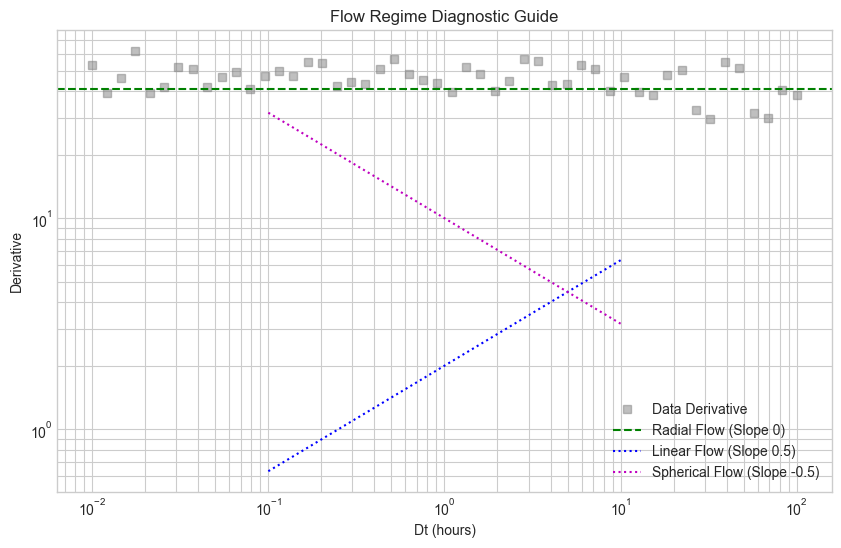

In [12]:
# Visualization helper: Plot slope guide lines
plt.figure(figsize=(10, 6))

# Plot the same derivative data from Section 5
plt.loglog(dt_values, derivative, 's', color='gray', alpha=0.5, label='Data Derivative')

# Add Guide Lines for Regimes
# 1. Radial Flow (Slope 0)
plt.axhline(y=np.mean(derivative[-10:]), color='g', linestyle='--', label='Radial Flow (Slope 0)')

# 2. Linear Flow (Slope 0.5) - Arbitrary intercept for visualization
x_lin = np.linspace(0.1, 10, 10)
y_lin = 2 * (x_lin ** 0.5) 
plt.loglog(x_lin, y_lin, 'b:', label='Linear Flow (Slope 0.5)')

# 3. Spherical Flow (Slope -0.5)
y_sph = 10 * (x_lin ** -0.5)
plt.loglog(x_lin, y_sph, 'm:', label='Spherical Flow (Slope -0.5)')

plt.title('Flow Regime Diagnostic Guide')
plt.xlabel('Dt (hours)')
plt.ylabel('Derivative')
plt.legend()
plt.grid(True, which="both")
plt.show()

## 6. Radius of Investigation
It is critical to calculate how far the pressure transient has traveled into the reservoir to ensure we are testing a representative volume.

$$r_{inv} = \sqrt{\frac{k t}{948 \phi \mu c_t}}$$

* $t$ = duration of flow or shut-in (hours)

In [7]:
def calculate_radius_of_investigation(t, k, poro, mu, ct):
    """
    Calculates Radius of Investigation (rinv) in ft.
    """
    return np.sqrt((k * t) / (948 * poro * mu * ct))

r_inv_end = calculate_radius_of_investigation(tp, k_calc, res_props.poro, res_props.mu, res_props.ct)
print(f"Radius of Investigation at end of test: {r_inv_end:.0f} ft")

Radius of Investigation at end of test: 2188 ft


## 7. Advanced Topic: Gas Well Testing (Pseudo-Pressure)
For gas reservoirs, the diffusivity equation is non-linear. We must transform pressure into **Real Gas Pseudo-Pressure ($m(p)$)** to linearize the equation and apply the same liquid solutions (Horner, etc.).

$$m(p) = 2 \int_{P_{base}}^P \frac{P}{\mu_z z} dP$$

In [8]:
from scipy.integrate import cumtrapz

def calculate_pseudo_pressure(p_range, mu_g_func, z_func, temp_rankine):
    """
    Calculates Real Gas Pseudo-Pressure m(p).
    p_range: Array of pressure values (psi) to integrate over
    mu_g_func: Function accepting P, T returning viscosity
    z_func: Function accepting P, T returning z-factor
    """
    # 1. Calculate 2 * P / (mu * z) for each pressure step
    integrand = []
    for p in p_range:
        mu = mu_g_func(p, temp_rankine)
        z = z_func(p, temp_rankine)
        val = (2 * p) / (mu * z)
        integrand.append(val)
        
    # 2. Integrate using Trapezoidal rule
    mp = cumtrapz(integrand, p_range, initial=0)
    return mp

# Note: To implement this fully, you would need Gas PVT correlations 
# (Lee-Gonzalez-Eakin for viscosity, Standing/Hall-Yarborough for Z-factor).
# This is often handled in a separate PVT module in professional projects.

## 8. Reservoir Limit Test (Boundary Estimation)
If the test is long enough to reach Pseudo-Steady State (PSS), the pressure drops linearly with time. We can estimate the **Drainage Area ($A$)** and **Pore Volume ($V_p$)**.

$$m_{pss} = \frac{0.2339 q B}{A h \phi c_t}$$

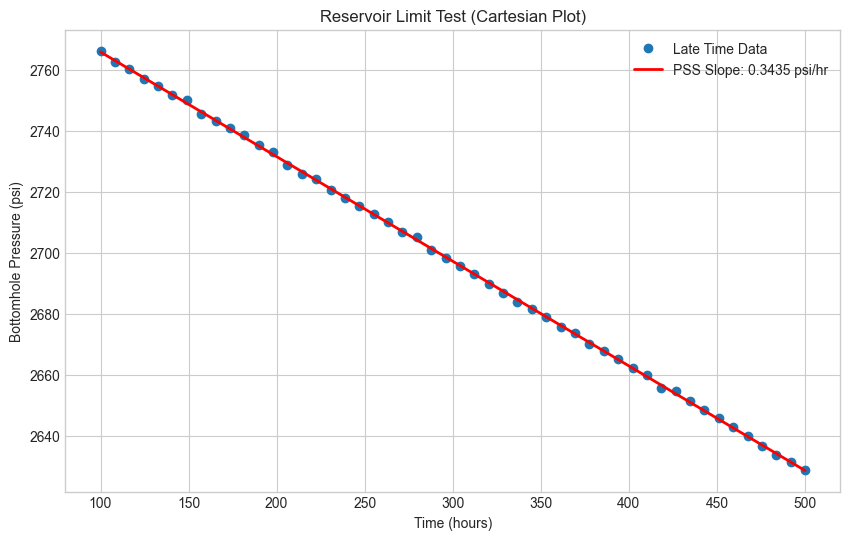

--- RESERVOIR LIMIT RESULTS ---
PSS Slope (m*): 0.34347 psi/hr
Calculated Pore Volume: 52.21 MMcf
Calculated Drainage Area: 159.8 acres (True: 160 acres)


In [9]:
# --- 1. Simulate Late-Time Data (Boundary Dominated Flow) ---
# We simulate a Long Drawdown Test where boundaries are felt
t_late = np.linspace(100, 500, 50)  # Late time: 100 to 500 hours
q_limit = 800  # STB/D
# True Area to simulate: 160 acres
true_area_ft2 = 160 * 43560 
true_pore_volume = true_area_ft2 * res_props.poro * res_props.h

# Calculate Theoretical PSS Slope (psi/hour)
# m_pss = (0.2339 * q * B) / (Vp * ct)
m_pss_theo = (0.2339 * q_limit * res_props.Bo) / (true_pore_volume * res_props.ct)

# Generate Pressure: Start from an arbitrary pressure and decline linearly
p_start_late = 2800 
p_late = p_start_late - (m_pss_theo * t_late)

# Add noise
p_late_noisy = p_late + np.random.normal(0, 0.5, size=len(t_late))

# --- 2. Cartesian Plot Analysis ---
plt.figure(figsize=(10, 6))
plt.plot(t_late, p_late_noisy, 'o', label='Late Time Data')

# Fit a straight line (Cartesian: P vs t)
coeffs_limit = np.polyfit(t_late, p_late_noisy, 1)
m_pss_calc = -coeffs_limit[0]  # Slope is negative, take absolute value
intercept_limit = coeffs_limit[1]

plt.plot(t_late, coeffs_limit[0]*t_late + intercept_limit, 'r-', linewidth=2, label=f'PSS Slope: {m_pss_calc:.4f} psi/hr')

plt.title('Reservoir Limit Test (Cartesian Plot)')
plt.xlabel('Time (hours)')
plt.ylabel('Bottomhole Pressure (psi)')
plt.legend()
plt.grid(True)
plt.show()

# --- 3. Calculation of Reserves ---
# Calculate Pore Volume (cubic feet)
# Vp = (0.2339 * q * B) / (m_pss * ct)
vp_calc = (0.2339 * q_limit * res_props.Bo) / (m_pss_calc * res_props.ct)

# Calculate Drainage Area (square feet and acres)
area_ft2_calc = vp_calc / (res_props.poro * res_props.h)
area_acres_calc = area_ft2_calc / 43560

print(f"--- RESERVOIR LIMIT RESULTS ---")
print(f"PSS Slope (m*): {m_pss_calc:.5f} psi/hr")
print(f"Calculated Pore Volume: {vp_calc/1e6:.2f} MMcf")
print(f"Calculated Drainage Area: {area_acres_calc:.1f} acres (True: 160 acres)")

## 9. Average Reservoir Pressure (MBH Method)
The Horner plot gives us $P^*$, which is the extrapolated pressure at "infinite" shut-in time. However, in a finite reservoir, we need the **Average Reservoir Pressure ($\bar{P}$)**.

The **Matthews-Brons-Hazelbroek (MBH)** method corrects $P^*$ to $\bar{P}$ using dimensionless pressure functions ($P_{DMBH}$).

$$\bar{P} = P^* - \frac{m}{2.303} P_{DMBH}(t_{DA})$$

Where $t_{DA}$ is the dimensionless time based on drainage area $A$:
$$t_{DA} = \frac{0.0002637 k t_p}{\phi \mu c_t A}$$

*Note: $P_{DMBH}$ is usually read from charts for specific reservoir shapes (Square, Rectangle, Circle). Below is a simplified approximation for a well in the center of a square.*

In [13]:
def calculate_MBH_pressure(p_star, m, tp, k, poro, mu, ct, area_acres):
    """
    Calculates Average Reservoir Pressure using MBH Method.
    Assumes: Well in center of a square drainage area.
    """
    # 1. Calculate Area in sq ft
    area_ft2 = area_acres * 43560
    
    # 2. Calculate t_DA (Dimensionless Time based on Area)
    # t_DA = (0.0002637 * k * tp) / (phi * mu * ct * A)
    t_da = (0.0002637 * k * tp) / (poro * mu * ct * area_ft2)
    
    # 3. Estimate P_DMBH (Dimensionless Pressure MBH)
    # Using a simplified correlation for a Square shape for t_DA > 0.1
    # For exact work, one would use the lookup table from the book.
    if t_da < 0.1:
        # Early time approximation (Infinite acting)
        p_dmbh = 0 
    else:
        # Late time approximation (Linear) for square
        # P_DMBH approx 4 * pi * t_da (very rough approx for demonstration)
        # Better Correlation for Center of Square (Earlougher):
        p_dmbh = np.log(4 * area_ft2 / (1.781 * 31.62)) # This is actually log(CA), let's use the linear PSS relation
        # In PSS: PD_MBH = 4 * pi * t_da - ln(CA) ... 
        # Let's use the explicit conversion from the book's chart logic:
        # For t_DA > 0.6, P_DMBH = 4 * pi * t_DA (approx)
        p_dmbh = 4 * np.pi * t_da

    # 4. Calculate P_bar
    # P_bar = P* - (m / 2.303) * P_DMBH
    p_bar = p_star - (m / 2.303) * p_dmbh
    
    return p_bar, t_da

# Example Usage
# Using results from our previous Horner Analysis:
# p_star (extrapolated) is the 'intercept' from our Horner Fit (at log(1)=0)
p_star_val = intercept # From Horner Section
m_val = slope_m        # From Horner Section
area_est = 160         # Acres

p_avg, tda_calc = calculate_MBH_pressure(p_star_val, m_val, tp, k_calc, res_props.poro, res_props.mu, res_props.ct, area_est)

print(f"--- MBH PRESSURE CORRECTION ---")
print(f"Extrapolated Pressure (P*): {p_star_val:.2f} psi")
print(f"Dimensionless Time (t_DA): {tda_calc:.4f}")
print(f"Corrected Average Pressure (P_bar): {p_avg:.2f} psi")

--- MBH PRESSURE CORRECTION ---
Extrapolated Pressure (P*): 2475.26 psi
Dimensionless Time (t_DA): 0.1716
Corrected Average Pressure (P_bar): 2372.31 psi
